In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import ipyvolume as ipv
import napari
import itk
from itkwidgets import view

import smorph as sm

In [2]:
IMAGE = 'Datasets/autocrop/C1-M1_LEFT _CA1.tif'

In [3]:
original = io.imread(IMAGE)

In [4]:
def showXYZprojn(img, voxel_sz_x, voxel_sz_y, voxel_sz_z):
    aspect_xz = voxel_sz_z / voxel_sz_x
    aspect_yz = voxel_sz_z / voxel_sz_y
    plt.imshow(np.max(img, axis=0), 'gray')
    plt.show()

    plt.imshow(np.max(img, axis=1), 'gray', aspect=aspect_xz)
    plt.show()

    plt.imshow(np.max(img, axis=2), 'gray', aspect=aspect_yz)
    plt.show()

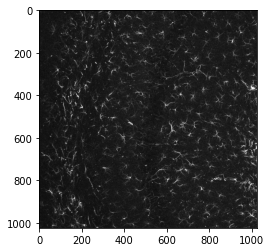

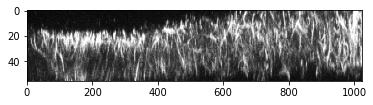

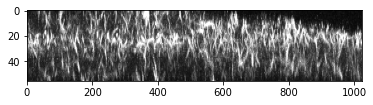

In [5]:
showXYZprojn(original, 0.52, 0.52, 2)

In [6]:
# itk_image = itk.image_view_from_array(original)
# itk_image.SetSpacing([.52, .52, 2])
# view(itk_image)

In [7]:
from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_bilateral,
    denoise_wavelet,
    estimate_sigma
)
from skimage import img_as_float
from skimage.util import random_noise
from skimage.exposure import rescale_intensity
from skimage.filters import threshold_otsu
from skimage.util import invert

In [8]:
denoised = np.zeros(original.shape)
denoised = denoise_tv_chambolle(original, multichannel=True)

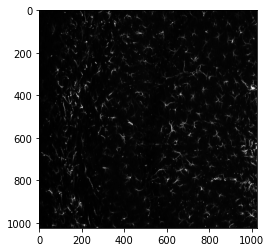

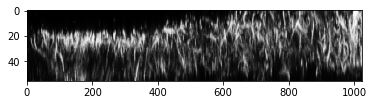

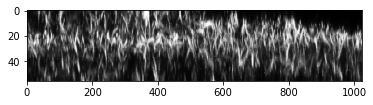

In [9]:
showXYZprojn(denoised, 0.52, 0.52, 2)
denoised_max_projn = np.max(denoised, 0)

In [10]:
# itk_image = itk.image_view_from_array(denoised/np.max(denoised)*255)
# itk_image.SetSpacing([.52, .52, 2])
# view(itk_image)

In [11]:
with napari.gui_qt():
    viewer = napari.view_image(denoised)

In [ ]:
manual_cropped_denoised_cell = original[:36, 490:610, 580:660]
manual_cropped_denoised_cell = (manual_cropped_denoised_cell / manual_cropped_denoised_cell * 255).astype(np.uint8)

with napari.gui_qt():
    viewer = napari.view_image(manual_cropped_denoised_cell)

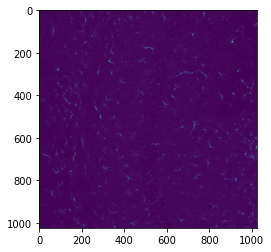

In [12]:
futile_denoised = denoise_tv_chambolle(original[30], weight=.02)
plt.imshow(futile_denoised)

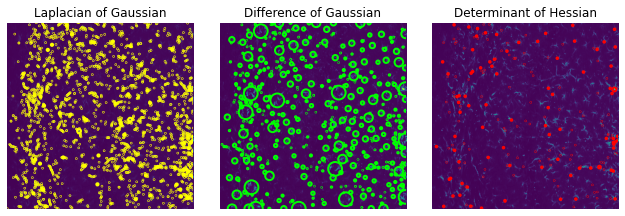

In [13]:
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt

blobs_log = blob_log(denoised_max_projn, max_sigma=30, num_sigma=10, threshold=.1)
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(denoised_max_projn, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(denoised_max_projn, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(denoised_max_projn)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

In [14]:
# ipv.figure()
# for j in range(denoised.shape[0]):
#     layer = np.where(denoised[j] > 0.35)
#     ipv.scatter(layer[0]/1023, layer[1]/1023, np.ones((1, layer[0].size))*0.006*j, 'black', size=.6, marker='box')
# ipv.show()

# Denoising microscope images

- Filters work by convolution w/ a moving window called a kernel.
- Convolution is multiplication of two arrays of different sizes. 
- Image will be of one size & kernel with be of a different size, usually much smaller than image
- Input pixel is at the centre of the kernel. Convolution is performed by sliding the kernel over the image, 

Linear filters and non-linear filters.
- Gaussian is an example of linear filter. 
- Non-linear filters preserve edges. Median filter is an example of non-linear filter. 
The algorithm selects the median value of all the pixels in the selected window
NLM: https://scikit-image.org/docs/dev/auto_examples/filters/plot_nonlocal_means.html

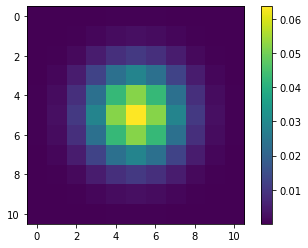

In [15]:
def gaussian_kernel(size, size_y=None):
    size = int(size)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-(x**2/float(size)+y**2/float(size_y)))
    return g / g.sum()

gaussian_kernel_array = gaussian_kernel(5)
plt.imshow(gaussian_kernel_array, interpolation='nearest')
plt.colorbar()
plt.show()

In [16]:
############################ Denoising filters ###############
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
from skimage import io
from scipy import ndimage as nd

img = img_as_float(original[30])
gaussian_img = nd.gaussian_filter(img, sigma=3)
median_img = nd.median_filter(img, size=3)

In [17]:
##### NLM #####
denoised_nlm = np.zeros(original.shape)
foriginal = img_as_float(original)
for j in range(original.shape[0]):
    img = foriginal[j]
    sigma_est = np.mean(estimate_sigma(img))
    denoised_nlm[j] = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=3)

# denoise_img_as_8byte = img_as_ubyte(denoise_img)

In [18]:
denoised_nlm_mc = np.zeros(original.shape)
sigma_est = np.mean(estimate_sigma(foriginal))
denoised_nlm_mc = denoise_nl_means(foriginal, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=3, multichannel=True)

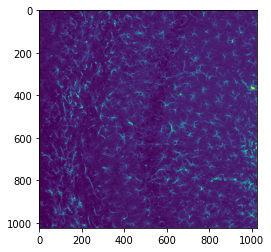

In [19]:
sigma_est = np.mean(estimate_sigma(denoised_nlm))
denoised_nlm = denoise_nl_means(denoised_nlm, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=3)
plt.imshow(denoise_tv_chambolle(np.max(denoised_nlm, axis=0), weight=.02))

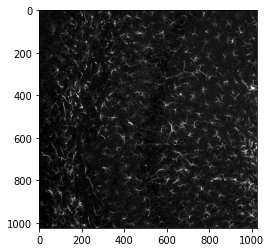

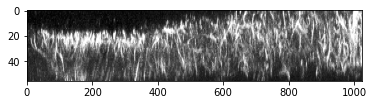

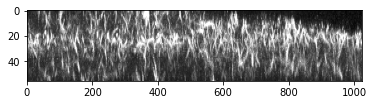

In [20]:
showXYZprojn(denoised_nlm, .52, .52, 2)

## Edge Detection

In [ ]:
from skimage.filters import farid
edge_boost_denoised = np.zeros(denoised.shape)

for j in range(denoised.shape[0]):
    edge_boost_denoised[j] = farid(denoised[j])

showXYZprojn(edge_boost_denoised, .52, .52, 2)

In [ ]:
with napari.gui_qt():
    viewer = napari.view_image(edge_boost_denoised)

## Threshold

In [ ]:
def _threshold_image(image, reference_image):
    """Single intensity threshold via Otsu's method."""
    if reference_image is not None:
        gray_reference_image = rgb2gray(reference_image)
        image = match_histograms(image, gray_reference_image)

    # Contrast stretching
    # p2, p98 = np.percentile(image, (2, 98))
    # img_rescale = rescale_intensity(image, in_range=(p2, p98))

    thresholded_cell = image > threshold_otsu(image)

    return thresholded_cell

thresholded = _threshold_image(np.max(denoised_nlm, 0), None)
sigma_est = np.mean(estimate_sigma(thresholded))
plt.imshow(denoise_nl_means(thresholded, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=3))

## 3D Segmentation

In [ ]:
# 2D layer-by-layer
import skimage.segmentation as seg

segmented_denoised = np.zeros(denoised.shape)

for j in range(denoised.shape[0]):
    segmented_denoised[j] = seg.chan_vese(denoised[j], .01)

showXYZprojn(segmented_denoised, .52, .52, 2)

In [ ]:
with napari.gui_qt():
    viewer = napari.view_image(segmented_denoised)

In [ ]:
# All 3D
from stardist.models import StarDist3D
from stardist.geometry import dist_to_coord3D
from csbdeep.utils import normalize
import time
print(time.localtime())

model = StarDist3D.from_pretrained('3D_demo')
labels, polys = model.predict_instances((denoised[:36, 490:610, 580:660] / np.max(denoised[:36, 490:610, 580:660]) * 255).astype(np.uint8))
print(time.localtime())
def surface_from_polys(polys):
    faces = polys["rays_faces"]
    print(time.localtime())
    coord = dist_to_coord3D(polys["dist"], polys["points"], polys["rays_vertices"])
    print(time.localtime())
    faces = np.concatenate([faces+coord.shape[1]*i for i in np.arange(len(coord))])
    print(time.localtime())
    vertices = np.concatenate(coord, axis=0)
    print(time.localtime())
    values = np.concatenate([np.random.rand()*np.ones(len(c)) for c in coord])
    print(time.localtime())
    return (vertices, faces, values)

surface = surface_from_polys(polys)
print(time.localtime())
with napari.gui_qt():
    viewer = napari.view_image((denoised[:36, 490:610, 580:660] / np.max(denoised[:36, 490:610, 580:660]) * 255).astype(np.uint8))
    viewer.add_surface(surface)